In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")


In [41]:
from utils import (
    extract_page_components, 
    extract_main_domain, 
    get_date_columns, 
    remove_incomplete_rows, 
    plot_time_series, 
    plot_seasonal_decompose,
    check_stationarity
)

In [4]:
data = pd.read_csv('../data/train_2.csv')
data.rename(columns={
    'Page': 'page'
}, inplace=True)
data.shape

(145063, 804)

In [28]:
date_columns = get_date_columns(data)

In [34]:
t_data = data.dropna().iloc[:10, :].copy()
t_data

,page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,74.0,39.0,11.0,55.0,71.0,44.0,25.0,39.0,25.0,50.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,53.0,107.0,63.0,42.0,24.0,44.0,33.0,52.0,21.0,48.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,20.0,16.0,22.0,19.0,21.0,32.0,34.0,29.0,23.0,25.0
11,Ahq_e-Sports_Club_zh.wikipedia.org_all-access_...,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,...,10.0,13.0,8.0,16.0,6.0,12.0,6.0,8.0,6.0,13.0
12,All_your_base_are_belong_to_us_zh.wikipedia.or...,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,...,7.0,4.0,5.0,10.0,7.0,4.0,2.0,6.0,2.0,22.0


In [35]:
t_data.set_index('page', inplace=True)
t_data = t_data.T
t_data.index = pd.to_datetime(t_data.index)
t_data.head()

page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,Ahq_e-Sports_Club_zh.wikipedia.org_all-access_spider,All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider
2015-07-01,18.0,11.0,1.0,35.0,12.0,118.0,5.0,6.0,2.0,2.0
2015-07-02,11.0,14.0,0.0,13.0,7.0,26.0,23.0,3.0,1.0,5.0
2015-07-03,5.0,15.0,1.0,10.0,4.0,30.0,14.0,5.0,4.0,5.0
2015-07-04,13.0,18.0,1.0,94.0,5.0,24.0,12.0,12.0,4.0,1.0
2015-07-05,14.0,11.0,0.0,4.0,20.0,29.0,9.0,6.0,2.0,3.0


### Baseline ARIMA

In [110]:
def fit_arima(series, p, d, q, exog=None):
    model = ARIMA(series, exog=exog, order=(p, d, q))
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            fitted_model = model.fit()
    except Exception as e:
        print(f"Fitting ARIMA({p},{d},{q}) failed with default start parameters: {e}")
        # Retry with initial parameters set to zero
        fitted_model = model.fit(start_params=[0] * (p + q))
    return fitted_model


def find_best_arima_model(time_series, p_values, d_values, q_values, exog=None):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                if True:
                    model = fit_arima(time_series, p, d, q, exog)
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                # except Exception as e:
                    # print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
    
    return {"order": best_order, "model": best_model, "aic": best_aic}

In [133]:
def get_time_series_and_exog(data, page_name):
    time_series = data[page_name]
    time_series = time_series.asfreq('D')
    day_of_week = pd.to_datetime(time_series.index).dayofweek
    exog = pd.get_dummies(day_of_week, prefix='dow').astype(int)

    exog.index = time_series.index
    
    return time_series, exog

In [134]:
def train_test_split(series, exog, test_size):
    train = series[:-test_size]
    test = series[-test_size:]
    train_exog = exog[:-test_size]
    test_exog = exog[-test_size:]
    return train, test, train_exog, test_exog

In [135]:
def process_page(page_name, data, date_columns, p_values, d_values, q_values, test_size):
    print(f"Processing ARIMA models for page: {page_name}")
        
    # Get the time series data for the page
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    # Skip the current iteration if no data was found
    if time_series is None:
        return

    # Determine if the series is stationary
    is_stationary = check_stationarity(time_series)

    # Adjust d_values based on stationarity
    adjusted_d_values = [0] if is_stationary else d_values

    # Split the data into training and testing sets
    train_series, test_series, train_exog, test_exog =  train_test_split(time_series, exog, test_size)

    # Find the best ARIMA model for the time series
    best_model_info = find_best_arima_model(train_series, p_values, adjusted_d_values, q_values, exog=train_exog)
    
    print(f"Best ARIMA model for {page_name}: Order={best_model_info['order']} AIC={best_model_info['aic']:.2f}")

    return best_model_info


def process_all_pages(data, date_columns, p_values, d_values, q_values, test_size):
    results = {}
    
    # Iterate over all unique pages in the DataFrame
    for page_name in data.columns:
        best_model_info = process_page(page_name, data, date_columns, p_values, d_values, q_values, test_size)
        if best_model_info is not None:
            results[page_name] = best_model_info

    return results

In [168]:
p_values = [30]
d_values = [0, 1]
q_values = [30]

test_size = 30
best_models_per_page = process_all_pages(t_data, date_columns, p_values, d_values, q_values, test_size)

Processing ARIMA models for page: 2NE1_zh.wikipedia.org_all-access_spider
Best ARIMA model for 2NE1_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=7300.29
Processing ARIMA models for page: 2PM_zh.wikipedia.org_all-access_spider
Best ARIMA model for 2PM_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=8062.20
Processing ARIMA models for page: 3C_zh.wikipedia.org_all-access_spider
Best ARIMA model for 3C_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=5957.91
Processing ARIMA models for page: 4minute_zh.wikipedia.org_all-access_spider
Best ARIMA model for 4minute_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=6626.13
Processing ARIMA models for page: 5566_zh.wikipedia.org_all-access_spider
Best ARIMA model for 5566_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=6403.09
Processing ARIMA models for page: A'N'D_zh.wikipedia.org_all-access_spider
Best ARIMA model for A'N'D_zh.wikipedia.org_all-access_spider: Order=(30, 0, 30) AIC=8141.32
Pr

In [169]:
def check_residuals(model):
    residuals = model.resid
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    residuals.plot(ax=ax[0], title="Residuals")
    residuals.plot(kind='kde', ax=ax[1], title="Density")
    plt.show()

def plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(train_series, label='Train', color='blue', linewidth=1)
    ax.plot(test_series, label='Test', color='orange', linewidth=1)
    
    # In-sample forecast
    in_sample_forecast = model.fittedvalues
    ax.plot(in_sample_forecast, label='In-sample Forecast', color='green', linestyle='--', linewidth=2)
    
    # Out-of-sample forecast
    forecast = model.get_forecast(steps=len(test_series), exog=test_exog)
    forecast_index = pd.date_range(start=test_series.index[0], periods=len(test_series), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    ax.plot(forecast_series, label='Out-of-sample Forecast', color='red', linestyle='--', linewidth=2)
    
    # Adding titles and labels
    ax.set_title('Actual vs Forecasted Values', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Page Views', fontsize=14)
    
    # Adding legend
    ax.legend(loc='upper left', fontsize=12)
    
    # Adding grid for better readability
    ax.grid(True)
    
    # Improving the appearance
    plt.tight_layout()
    
    plt.show()

def plot_model_forecast(data, best_models_per_page, date_columns, page_name, test_size):
    if page_name not in best_models_per_page:
        print(f"No model found for page: {page_name}")
        return
    
    best_model_info = best_models_per_page[page_name]
    model = best_model_info['model']
    
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    if time_series is not None:
        train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
        plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model)
        check_residuals(model)

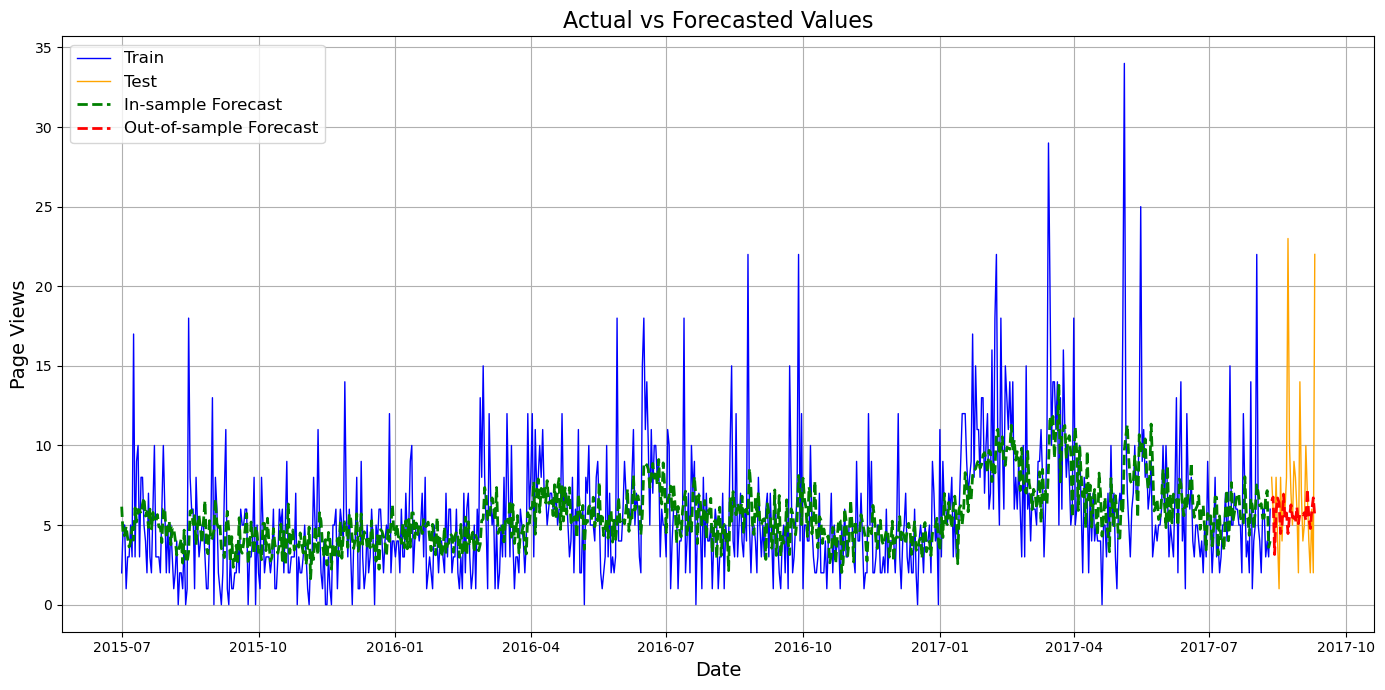

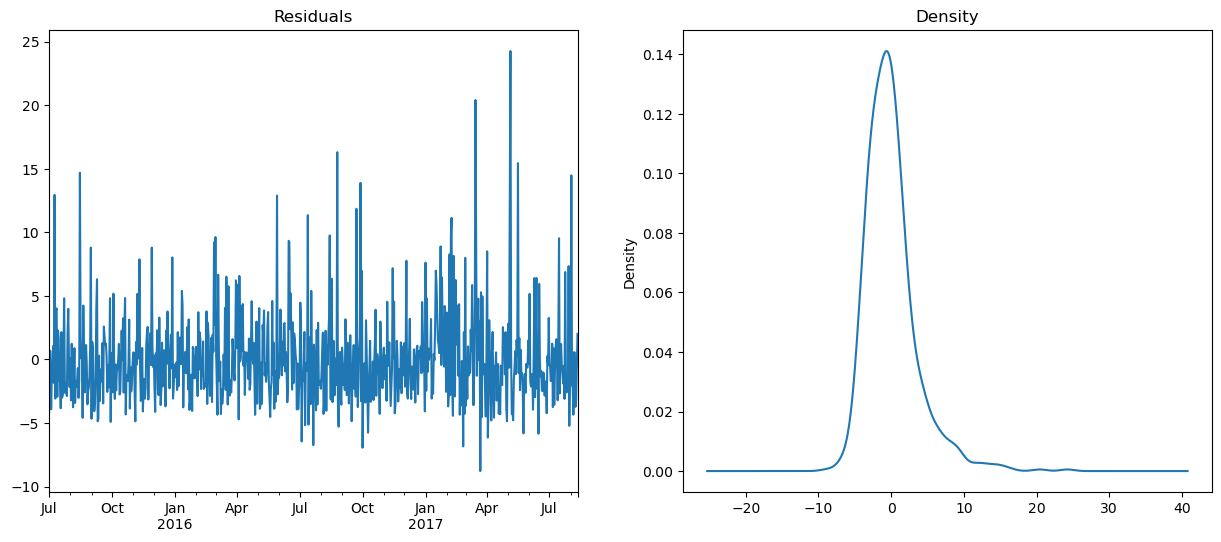

In [171]:
page_name = 'All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider'

plot_model_forecast(t_data, best_models_per_page, date_columns, page_name, test_size)